<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/ML_T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tarea 1. Aprendizaje máquina.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

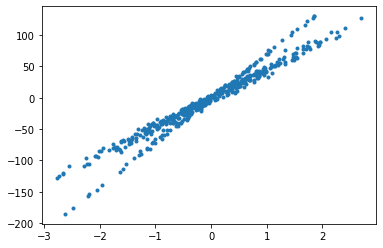

In [11]:
from sklearn import linear_model, datasets

n_samples = 500
X, y = datasets.make_regression(n_samples=n_samples,
                                n_features=1,
                                n_informative=2, 
                                noise=5,
                                random_state=0) #2)
n_outliers=100
X[:n_outliers], y[:n_outliers] = datasets.make_regression(n_samples=n_outliers,
                                n_features=1,
                                n_informative=2, 
                                noise=2,
                                random_state=61)
y=np.expand_dims(y,axis=1)
plt.scatter(X[:],y[:], marker='.')

In [12]:
alpha=0.1
def NAG(theta,alpha,eta,nIter, grad):
    '''
    Descenso acelerado de Nesterov
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    p     = np.zeros(theta.shape)
    Theta=[]
    
    for t in range(nIter):
        pre_theta = theta - 2.0*alpha*p
        g = grad(pre_theta)
        p = g + eta*p
        theta = theta - alpha*p
        Theta.append(theta)
    return np.array(Theta)

In [17]:
def grad(theta):
    err=theta[0]*X+theta[1]-y
    partial0=err
    partial1=X*partial0
    partial_t0=np.sum(partial0)
    partial_t1=np.sum(partial1)
    return np.array([partial_t1,partial_t0], dtype=object)

In [18]:
NAG(theta=np.array([-0.61752689 ,-0.76804482]),alpha=0.1,eta=0.9,nIter=100,grad=grad)

array([[2584.56328114749, -180.56255740834158],
       [-386508.8412588353, 56261.5963077469],
       [58774810.764920555, -12827885.438413136],
       [-8986094620.776062, 2586199951.0067387],
       [1381094464871.0918, -488374942758.4973],
       [-213312017147614.6, 88581714714327.08],
       [3.3098021728787964e+16, -1.5638071420940854e+16],
       [-5.157408895728845e+18, 2.708132554175389e+18],
       [8.067688856871641e+20, -4.623584421325497e+20],
       [-1.2664878246924896e+23, 7.808768675594121e+22],
       [1.994516498973554e+25, -1.3077434819473135e+25],
       [-3.150039808796051e+27, 2.1755056202728382e+27],
       [4.9877158030774114e+29, -3.599707514810002e+29],
       [-7.915340550835962e+31, 5.930375526917174e+31],
       [1.2586498419759656e+34, -9.735261186677794e+33],
       [-2.004948364299464e+36, 1.5934363938981875e+36],
       [3.198675288540363e+38, -2.6017230456216936e+38],
       [-5.110005875034683e+40, 4.239383832824629e+40],
       [8.173005459719827e+4